# Geospatial clustering and temporal contagion of sexual violence the Colombian armed conflict: 2014 - 2024

In [52]:
# Core Data Manipulation and Utilities ----------------------------------------
library(dplyr)             # Data manipulation (part of tidyverse but explicit)
library(tidyr)             # Data reshaping
library(purrr)             # Functional programming tools
library(stringr)           # String manipulation
library(janitor)           # Data cleaning utilities

# File I/O and Data Import/Export ---------------------------------------------- 
library(readxl)            # Read Excel files
library(writexl)           # Write Excel files

# Data Exploration and Summary Statistics -------------------------------------
library(skimr)             # Comprehensive data summaries
library(summarytools)      # Descriptive statistics and summaries
library(Hmisc)             # Statistical functions and summaries

# Visualization and Reporting --------------------------------------------------
library(ggplot2)           # Advanced plotting (part of tidyverse but explicit)
library(patchwork)         # Combine multiple plots
library(flextable)         # Create formatted tables
library(officer)           # Document generation utilities

# Statistical Modeling ---------------------------------------------------------
library(MASS)              # Statistical functions and kernel density estimation

# Geospatial Analysis ----------------------------------------------------------
# Basic spatial data handling
library(sf)                # Spatial data manipulation and analysis
library(maps)              # Country and region maps
library(rnaturalearth)     # Natural Earth map data
library(rnaturalearthdata) # Natural Earth map datasets

# Spatial Point Process Analysis
library(spatstat.geom)     # Spatial point pattern geometry
library(spatstat.linnet)   # Network-based spatial analysis
library(stpp)              # Spatiotemporal point processes

# Hawkes Process Modeling
library(hawkes)            # Basic Hawkes process modeling
library(hawkesbow)         # Extended Hawkes process tools
library(emhawkes)          # Enhanced Hawkes process fitting and comparison
library(stelfi)            # Hawkes and log-Gaussian Cox process models

# Log-Gaussian Cox Process (LGCP) Modeling
library(inlabru)           # LGCP model fitting and comparison
library(INLA)              # Integrated nested Laplace approximations
# Note: Install INLA with:
# install.packages("INLA", repos=c(getOption("repos"), 
#                  INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)


In [53]:
# Set random seed for reproducibility
set.seed(7550822)

### Import data files

In [54]:
# Path to data files
data_path <- "/Users/elisavetpappa/Dropbox/Mac/Desktop/Publications/Armed_Conflict/Cento_National_Data/Victimas"
data_path <- "/home/main/Dropbox/Studies/PAPSIVI_Paper3/LGCP Modelling/Data"

# Define the list of required columns
required_columns <- c("ID Caso", "Código DANE de Municipio", "Municipio", "Departamento", 
                      "Año", "Mes", "Día", "ID Persona", "Sexo", "Etnia", "Ocupación", 
                      "Calidad de la Víctima o la Baja", "Latitud", "Longitud", "Edad",
                      "Fuerza o Grupo Armado Organizado al que Pertenece el Combatiente", "Situación Actual de la Víctima", 
                      "Días de Cautiverio",  "No. de Veces secuestrado")


file_list <- list.files(path = data_path, pattern = "\\.xlsx$", full.names = TRUE)

# Exclude temporary files like ~$filename.xlsx
file_list <- file_list[!grepl("~\\$", basename(file_list))]

# Function to detect and convert data types
detect_and_convert_types <- function(df) {
  df_converted <- df
  
  for (col_name in names(df)) {
    col_data <- df[[col_name]]
    
    # Skip if all values are NA
    if (all(is.na(col_data))) {
      next
    }
    
    # Remove NA values for type detection
    non_na_values <- col_data[!is.na(col_data)]
    
    # Try to convert to numeric if it makes sense
    numeric_conversion <- suppressWarnings(as.numeric(non_na_values))
    
    # If conversion was successful for most values, treat as numeric
    if (sum(!is.na(numeric_conversion)) / length(non_na_values) > 0.8) {
      df_converted[[col_name]] <- suppressWarnings(as.numeric(col_data))
    } else {
      # Keep as character
      df_converted[[col_name]] <- as.character(col_data)
    }
  }
  
  return(df_converted)
}

data_list <- lapply(file_list, function(file) {
  # Read everything as text first to avoid type conflicts
  df <- read_excel(file, col_types = "text")
  
  # Automatically detect and convert data types
  df <- detect_and_convert_types(df)
  
  # Ensure required_columns is a character vector
  required_columns <- as.character(required_columns)
  
  # Ensure required columns exist
  missing_cols <- setdiff(required_columns, names(df))
  if (length(missing_cols) > 0) {
    df[missing_cols] <- NA
  }
  
  # Select only the required columns that exist
  df <- dplyr::select(df, intersect(names(df), required_columns))
  
  # Add file name as identifier
  df$Source_File <- basename(file)
  
  return(df)
})

### Data tidying

In [55]:
# Combine into single dataframe
combined_data <- bind_rows(data_list)

# Some data tidying
# Turns to snake_case, removes accents
combined_data <- janitor::clean_names(combined_data)  

# Replace all blank values with NA
combined_data[combined_data == ""] <- NA

# If columns are characters and might include blanks
combined_data <- combined_data %>%
  mutate(across(c(ano, mes, dia), ~ ifelse(. == 0 | . == "" | is.na(.), NA, .)))

# Ensure the columns are numeric
combined_data$ano <- as.numeric(combined_data$ano)
combined_data$mes <- as.numeric(combined_data$mes)
combined_data$dia <- as.numeric(combined_data$dia)

# Remove rows with any missing date parts
combined_data <- combined_data[complete.cases(combined_data[, c("ano", "mes", "dia")]), ]

# Combine year, month, day into a string
combined_data$DateString <- paste(combined_data$ano,
                                  sprintf("%02d", combined_data$mes),
                                  sprintf("%02d", combined_data$dia),
                                  sep = "-")

# Convert to POSIXct
combined_data$Date <- as.POSIXct(combined_data$DateString, format = "%Y-%m-%d", tz = "UTC")

# Recode violence event types
combined_data <- combined_data %>%
  plyr::mutate(EventType = case_when(
    source_file == "VictimasAB_202409.xlsx" ~ "AB", # Acciones Bélicas
    source_file == "VictimasAP_202409.xlsx" ~ "AP", # Ataques Poblaciones
    source_file == "VictimasAS_202409.xlsx" ~ "AS", # Asesinatos selectivos
    source_file == "VictimasAT_202409.xlsx" ~ "AT", # Atentados Terroristas
    source_file == "VictimasDB_202409.xlsx" ~ "DB", # Daños a bienes civiles
    source_file == "VictimasDF_202409.xlsx" ~ "DF", # Desaparición forzada
    source_file == "VictimasMA_202409.xlsx" ~ "MA", # Masacres
    source_file == "VictimasMI_202409.xlsx" ~ "MI", # Minas
    source_file == "VictimasRU_202409.xlsx" ~ "RU", # Reclutamiento y utilización de niños, niñas y adolescentes
    source_file == "VictimasSE_202409.xlsx" ~ "SE", # Secuestos
    source_file == "VictimasVS_202409.xlsx" ~ "VS", # Violencia sexual
    TRUE ~ NA_character_  # default case if no match
  ))


combined_data$EventType <- as.factor(combined_data$EventType)

# Filter for dates from 2014-01-01 onwards
combined_data_filtered <- combined_data %>%
  filter(DateString >= as.Date("2014-01-01"))

# Convert to POSIXct
combined_data_filtered$Date <- as.POSIXct(combined_data_filtered$DateString, format = "%Y-%m-%d", tz = "UTC")

# Convert to numeric time (e.g., for some Hawkes models)
combined_data_filtered$Timestamp <- as.numeric(combined_data_filtered$Date)

# Convert to spatial point pattern (longitude & latitude as spatial features)

# Define observation window (bounding box for spatial analysis)
W <- owin(xrange = c(min(combined_data_filtered$longitud), max(combined_data_filtered$longitud)), 
          yrange = c(min(combined_data_filtered$latitud), max(combined_data_filtered$latitud)))

# Convert to spatial point pattern using spatstat.geom
spatial_points <- ppp(combined_data_filtered$longitud, combined_data_filtered$latitud, window=W)

# Convert time dimension to relative time units
combined_data_filtered$Time <- as.numeric(difftime(combined_data_filtered$Timestamp, min(combined_data_filtered$Timestamp), units="days"))

# Remove missing timepoints
combined_data_filtered <- combined_data_filtered[!is.na(combined_data_filtered$Timestamp), ]

# Sort the data by time:
combined_data_filtered <- combined_data_filtered[order(combined_data_filtered$Timestamp), ]

# Jitter up to 10 minutes (in seconds) to avoid simultaneous events
combined_data_filtered$Timestamp <- combined_data_filtered$Timestamp + runif(nrow(combined_data_filtered), 0, 600)

# Sort again to make sure timestamps are strictly increasing
combined_data_filtered <- combined_data_filtered[order(combined_data_filtered$Timestamp), ]

#Convert to numeric relative time (in days or seconds):
combined_data_filtered$t <- as.numeric(difftime(combined_data_filtered$Timestamp, min(combined_data_filtered$Timestamp), units = "days"))
combined_data_filtered <- combined_data_filtered[order(combined_data_filtered$t), ]
combined_data_filtered$x <- combined_data_filtered$longitud
combined_data_filtered$y <- combined_data_filtered$latitud

# Convert data frame to an sf object
combined_data_filtered_sf <- st_as_sf(combined_data_filtered, coords = c("longitud", "latitud"), crs = 4326)

# Set the CRS to the desired one
st_crs(combined_data_filtered_sf) <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

# Filter out rows where coordinates are 0
combined_data_filtered_sf <- combined_data_filtered_sf %>%
  filter(st_coordinates(geometry)[,1] != 0 & st_coordinates(geometry)[,2] != 0)

# Filter out rows with non-finite Date values
combined_data_filtered_sf <- combined_data_filtered_sf %>%
  filter(!is.na(Date))

# Ensure the variable is in Date format
combined_data_filtered_sf$DateString <- as.Date(combined_data_filtered_sf$DateString)

# Extract the year from the date
combined_data_filtered_sf$Year <- format(combined_data_filtered_sf$DateString, "%Y")

# Convert year to numeric
combined_data_filtered_sf$Year <- as.numeric(combined_data_filtered_sf$Year)

# Only keep sexual violence events
SV_combined_data_filtered_sf <- combined_data_filtered_sf %>%
  filter(EventType == "VS")


Warning message:
“data contain duplicated points”


In [56]:
# Set image size
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 210)

### Descriptive plots

#### Frequency of sexual violence events over time

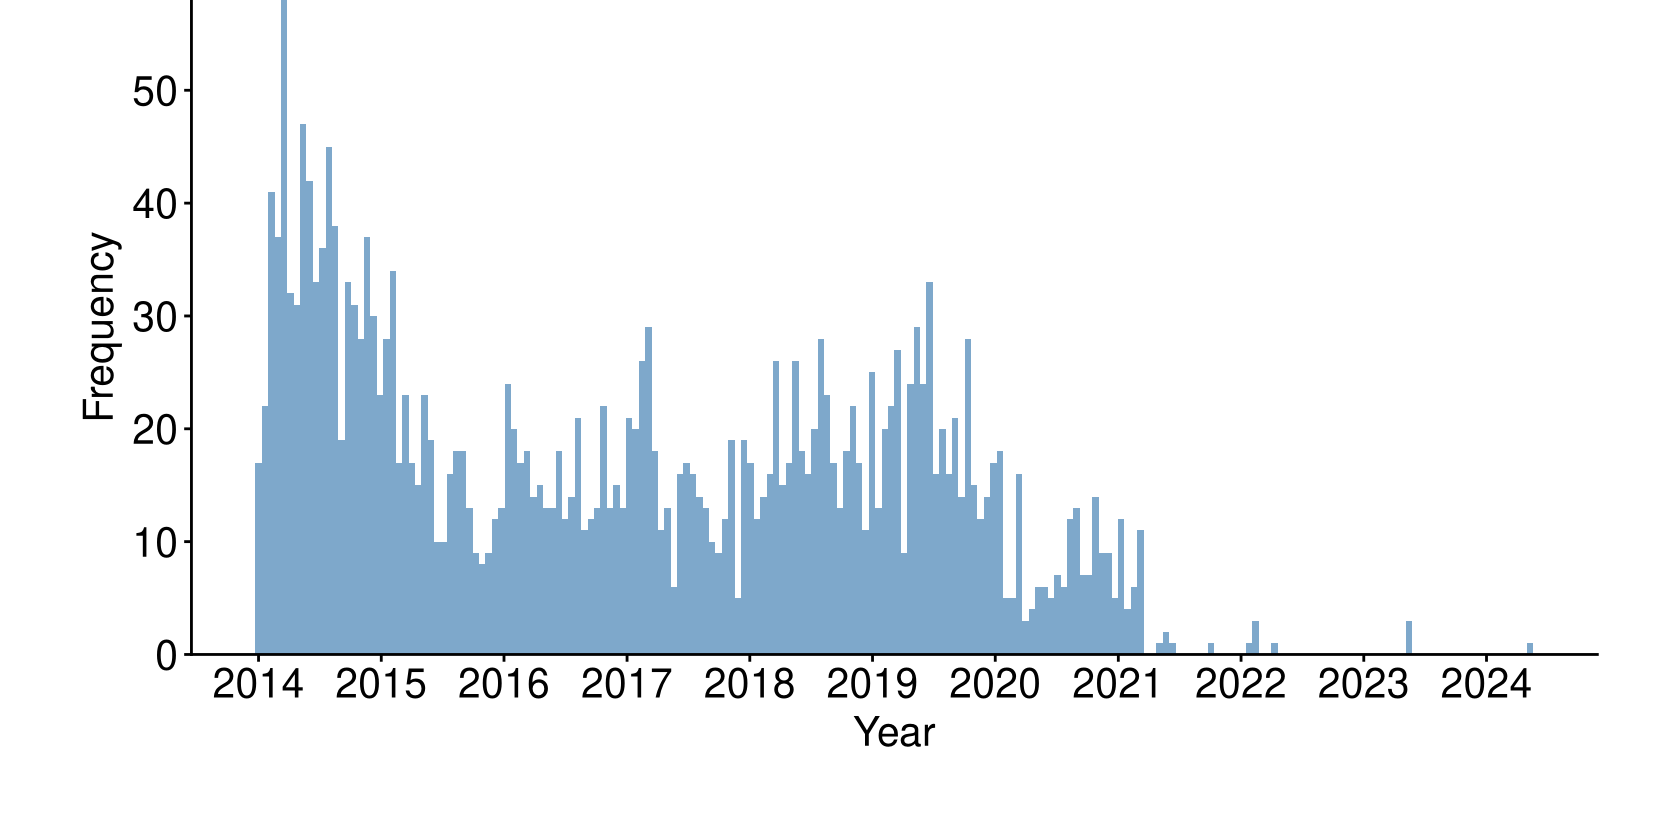

In [57]:
generate_total_histogram <- function(data, date_var = "Date") {
  ggplot(data, aes(x = .data[[date_var]])) +
    geom_histogram(bins = 200, alpha = 0.7, fill = "steelblue") +
    ylab("Frequency") +
    xlab("Year") +
    theme_classic(base_size = 10) +
    scale_y_continuous(limits = c(0, NA), expand = c(0, 0)) +
    scale_x_date(breaks = seq(as.Date("1960-01-01"), as.Date("2030-01-01"), by = "1 years"),
                 date_labels = "%Y") +
    theme(
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 14),
      plot.margin = margin(0, 1, 1, 1, "cm")
    )
}

# For the whole dataframe
total_plot <- generate_total_histogram(SV_combined_data_filtered_sf)
total_plot


#### Geospatial density map of sexual violence events during the armed conflict

In [58]:
# Set image size
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 210)

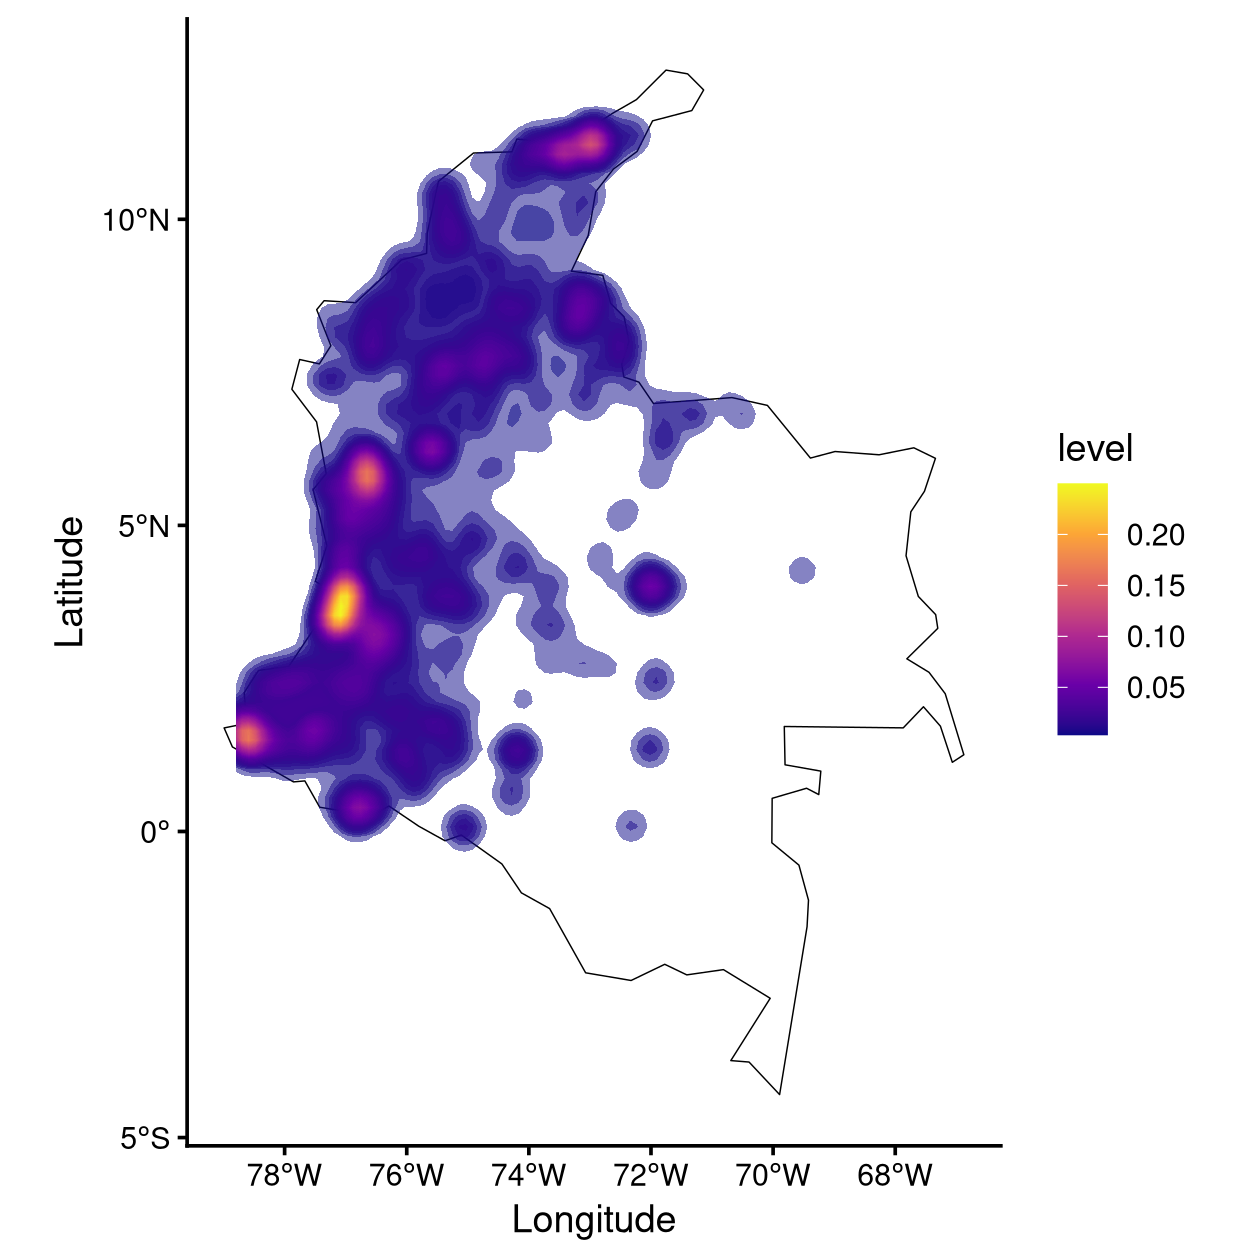

In [59]:
# Load map data for Colombia
colombia <- ne_countries(country = "Colombia", returnclass = "sf")

generate_density_map <- function(data) {
  coords <- sf::st_coordinates(data$geometry)
  data$lon <- coords[, 1]
  data$lat <- coords[, 2]
  
  ggplot() +
    geom_sf(data = colombia, fill = NA, color = "black") +
    stat_density_2d(
      data = data,
      aes(x = lon, y = lat, fill = after_stat(level)),
      geom = "polygon",
      alpha = 0.5,
      bins = 80,
      h = c(0.8, 0.8)
    ) +
    scale_fill_viridis_c(option = "C") +
    coord_sf() +
    theme_classic(base_size = 13) +
    xlab("Longitude") +
    ylab("Latitude") +
    theme(legend.position = "right")
}

generate_density_map(SV_combined_data_filtered_sf)

### Spatial log-Gaussian Cox process (LGCP) model

Data preparation

In [60]:
# Get the map of Colombia as an sf object
colombia <- ne_countries(country = "Colombia", returnclass = "sf") %>%
  sf::st_make_valid()

## get sf of the contiguous colombia
# Disable S2 geometry processing if needed
sf::sf_use_s2(FALSE)

# dataframe of sighting locations (lat, long)
locs <- sf::st_coordinates(SV_combined_data_filtered_sf) %>%
  as.data.frame() %>%
  rename(., c("x" = "X", "y" = "Y"))

# Delauney triangluation of domain
smesh <- INLA::inla.mesh.2d(loc = locs[, 1:2], max.edge = 2, cutoff = 1)

Fit LGCP model

In [61]:
fit <- fit_lgcp(locs = locs, sf = colombia, smesh = smesh,
                parameters = c(beta = 0, log_tau = log(1),
                               log_kappa = log(1)))

lgcp_model_coefs <- get_coefs(fit)

Show model parameters

In [62]:
print(round(lgcp_model_coefs, 3))

          Estimate Std. Error
beta         1.566      0.974
log_tau     -1.153      0.160
log_kappa   -0.663      0.241
range        5.491      1.322
stdev        1.734      0.307


In [63]:
## get weights used
w <- get_weights(smesh, sf = colombia)$weights

## extract field values at mesh nodes
f <- get_fields(fit, smesh)
sum(w * exp(f + get_coefs(fit)[1, 1])) 

[1] 2531.808

Plot mesh-based integration weights 

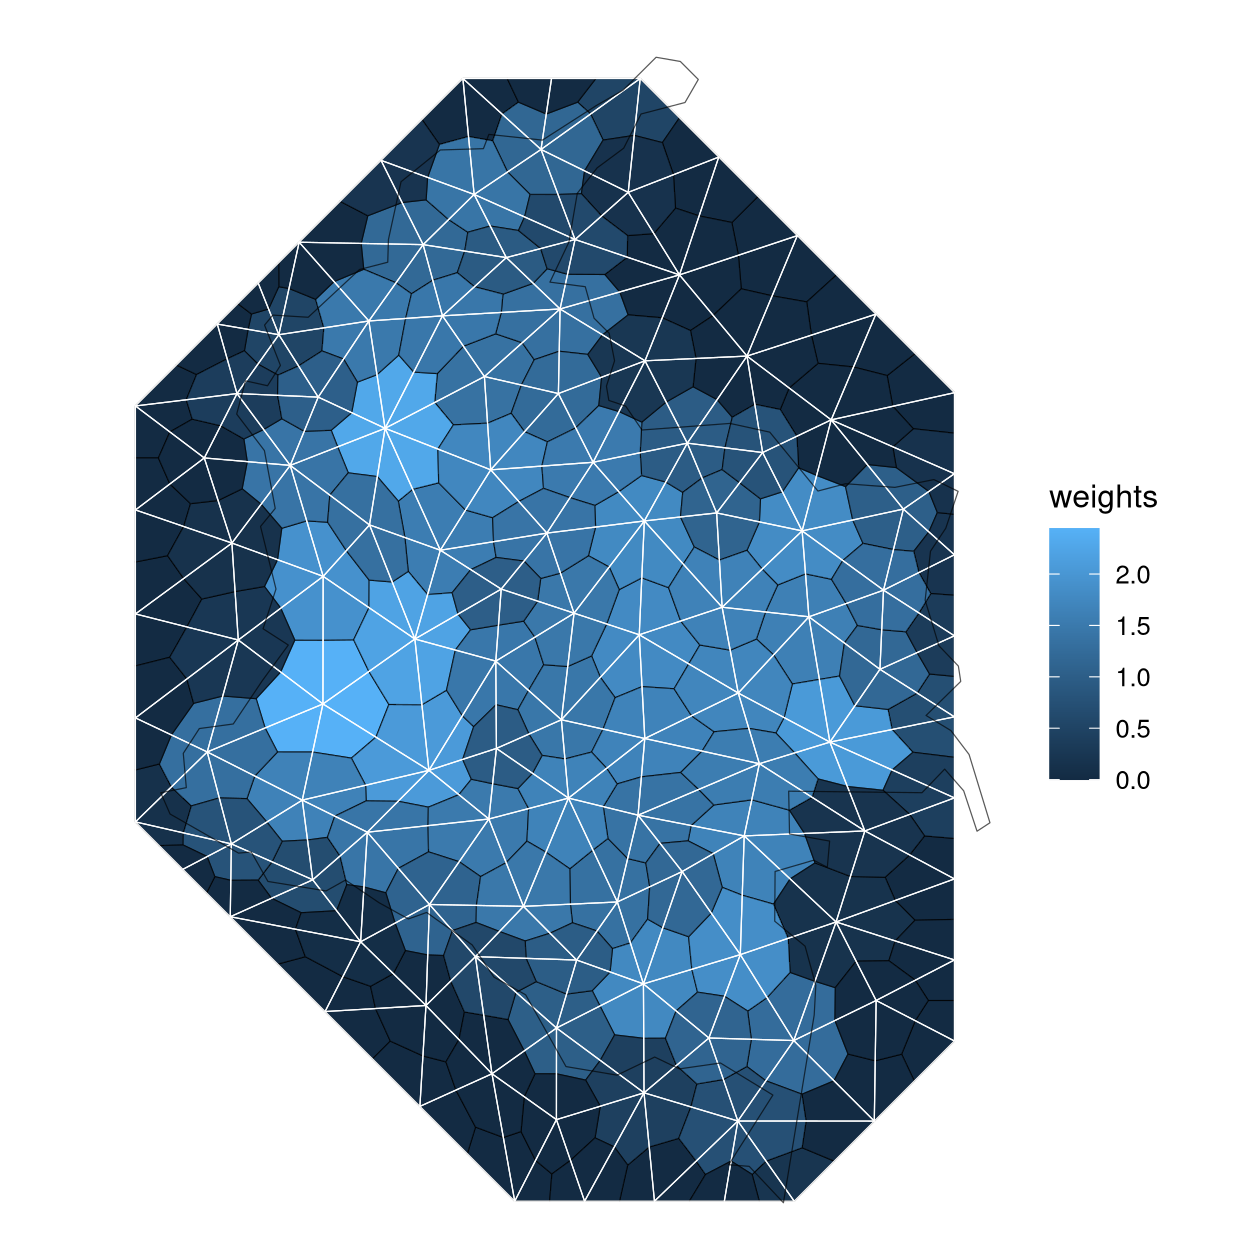

In [64]:
## plot mesh weights
weights_plot_col <- get_weights(smesh, sf = colombia, plot = TRUE)

#### LGCP intensity plot

although coordinates are longitude/latitude, st_intersects assumes that they
are planar

although coordinates are longitude/latitude, st_intersects assumes that they
are planar

Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


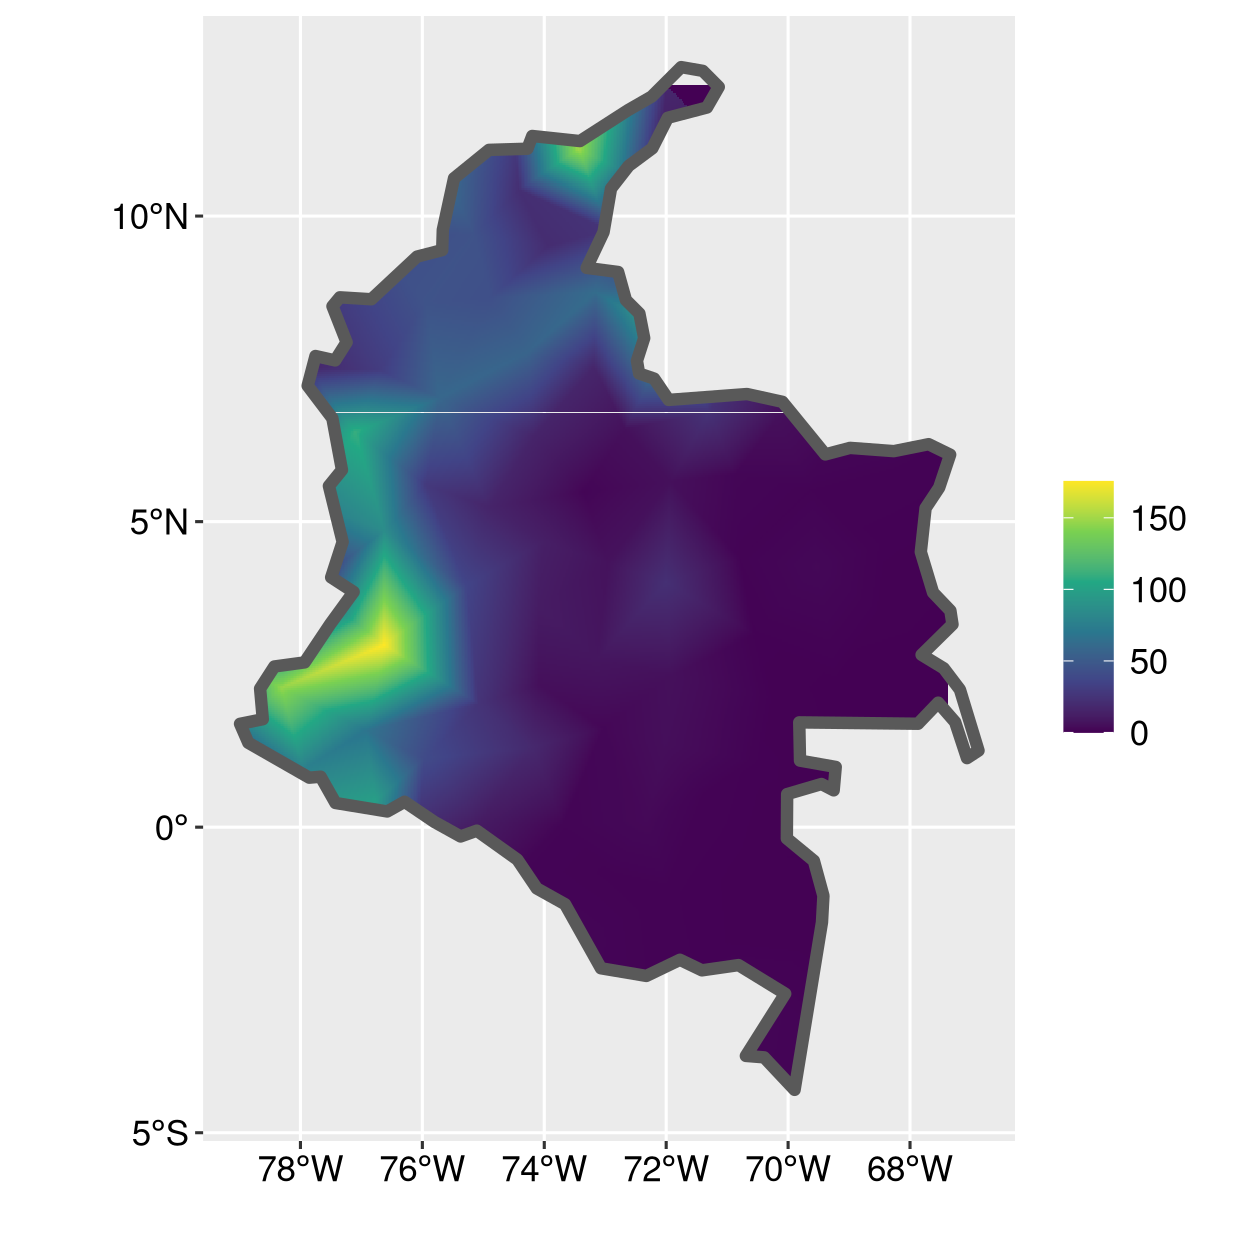

In [65]:
lambda_plot <- show_lambda(fit, smesh, sf = colombia, clip = TRUE)

# Add title
lambda_plot + theme(text = element_text(size = 14, color = "black"),
                    axis.title = element_text(size = 16, color = "black"),
                    axis.text = element_text(size = 12, color = "black"),
                    plot.title = element_text(size = 18, color = "black"),
                    legend.text = element_text(size = 12, color = "black"),
                    legend.title = element_text(size = 14, color = "black"))

#### Spatial projection of latent Gaussian Markov Random Field (GMRF) estimates

although coordinates are longitude/latitude, st_intersects assumes that they
are planar

although coordinates are longitude/latitude, st_intersects assumes that they
are planar

Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


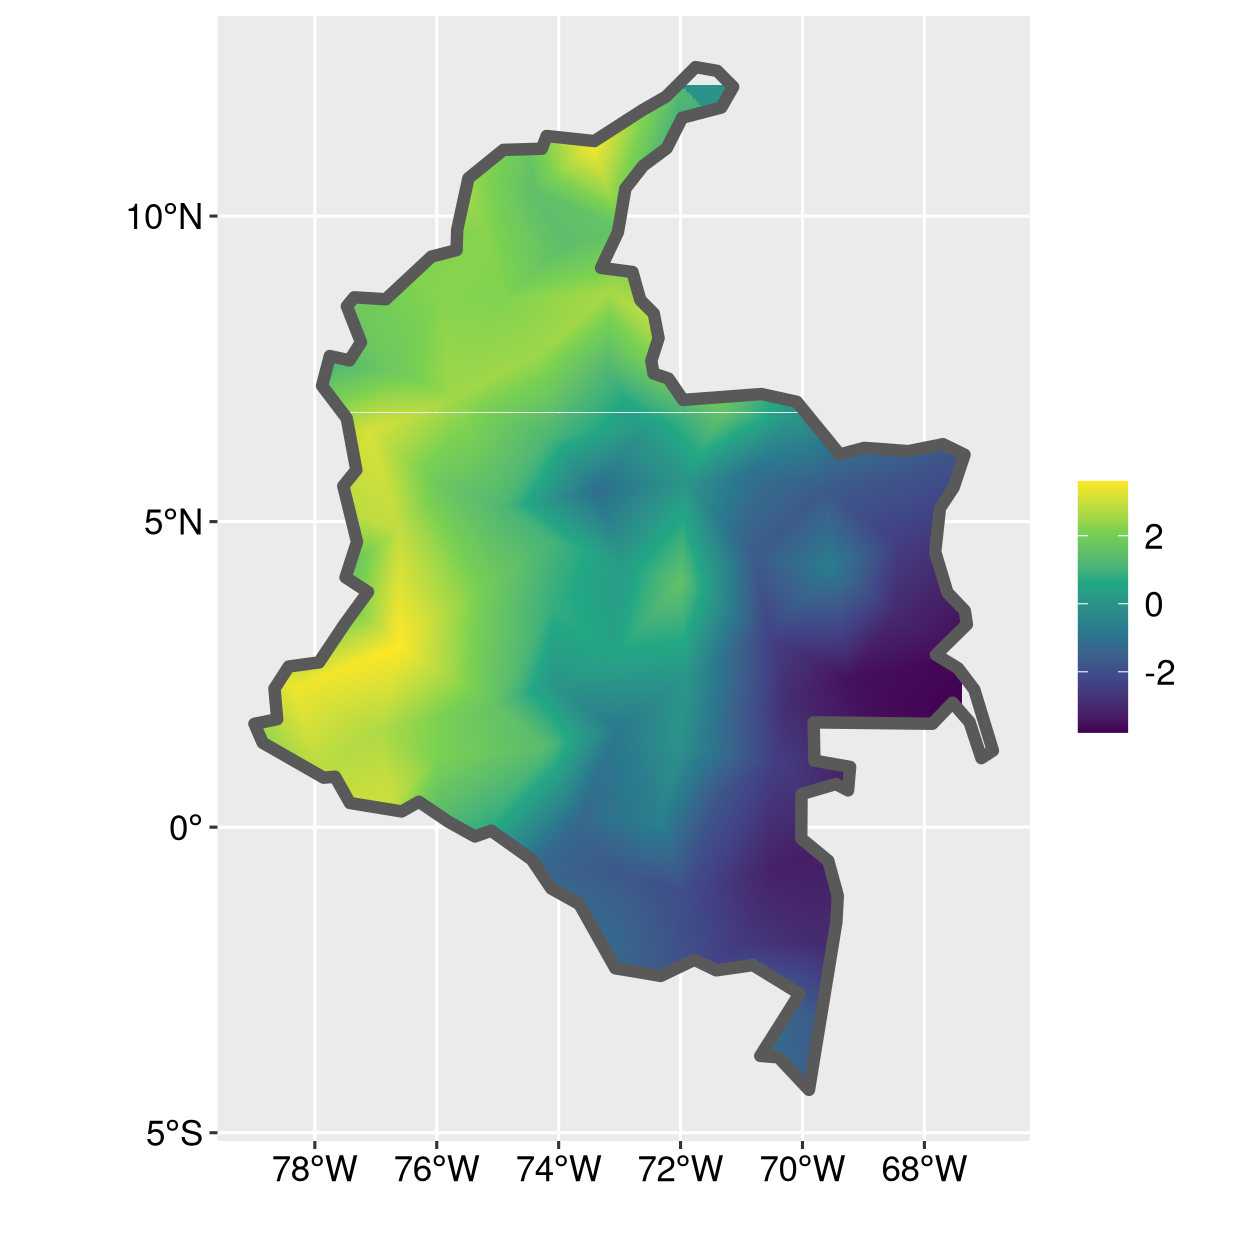

In [66]:
gmrf_field_plot <- get_fields(fit, smesh) |>
  show_field(smesh = smesh, sf = colombia, clip = TRUE)

gmrf_field_plot + theme(text = element_text(size = 14, color = "black"),
                        axis.title = element_text(size = 16, color = "black"),
                        axis.text = element_text(size = 12, color = "black"),
                        plot.title = element_text(size = 18, color = "black"),
                        legend.text = element_text(size = 12, color = "black"),
                        legend.title = element_text(size = 14, color = "black"))

### Hawkes process model

In [67]:
## Times must be unique and in ascending order
SV_times <- SV_combined_data_filtered_sf %>%
  mutate(time = difftime(Date, min(Date), units = "days")) %>% #Calculates the number of days since the earliest event in the dataset
  mutate(time = time + runif(nrow(SV_combined_data_filtered_sf), 0, 1)) %>% #Adds a tiny random jitter (up to 1 day) to each time value - avoiding identical timestamps 
  mutate(time = time - min(time)) %>% #Re-normalizes the time so that it starts at 0
  sf::st_drop_geometry() %>%  # Drop geometry if it's an sf object
  pull(time) %>%              # Pull 'time' as a vector
  as.numeric() %>%            # Convert to numeric
  sort()                      # Sort in ascending order

## Using stelfi library for fitting Hawkes and log-Gaussian Cox point process models
## parameter starting values
SV_params <- c(mu = 9, alpha = 0.3, beta = 1)

## fit model
fit <- fit_hawkes(times = SV_times, parameters = SV_params)

# Store parameters
hawkes_model_coefs <- get_coefs(fit)

Plot fitted Hawkes process model

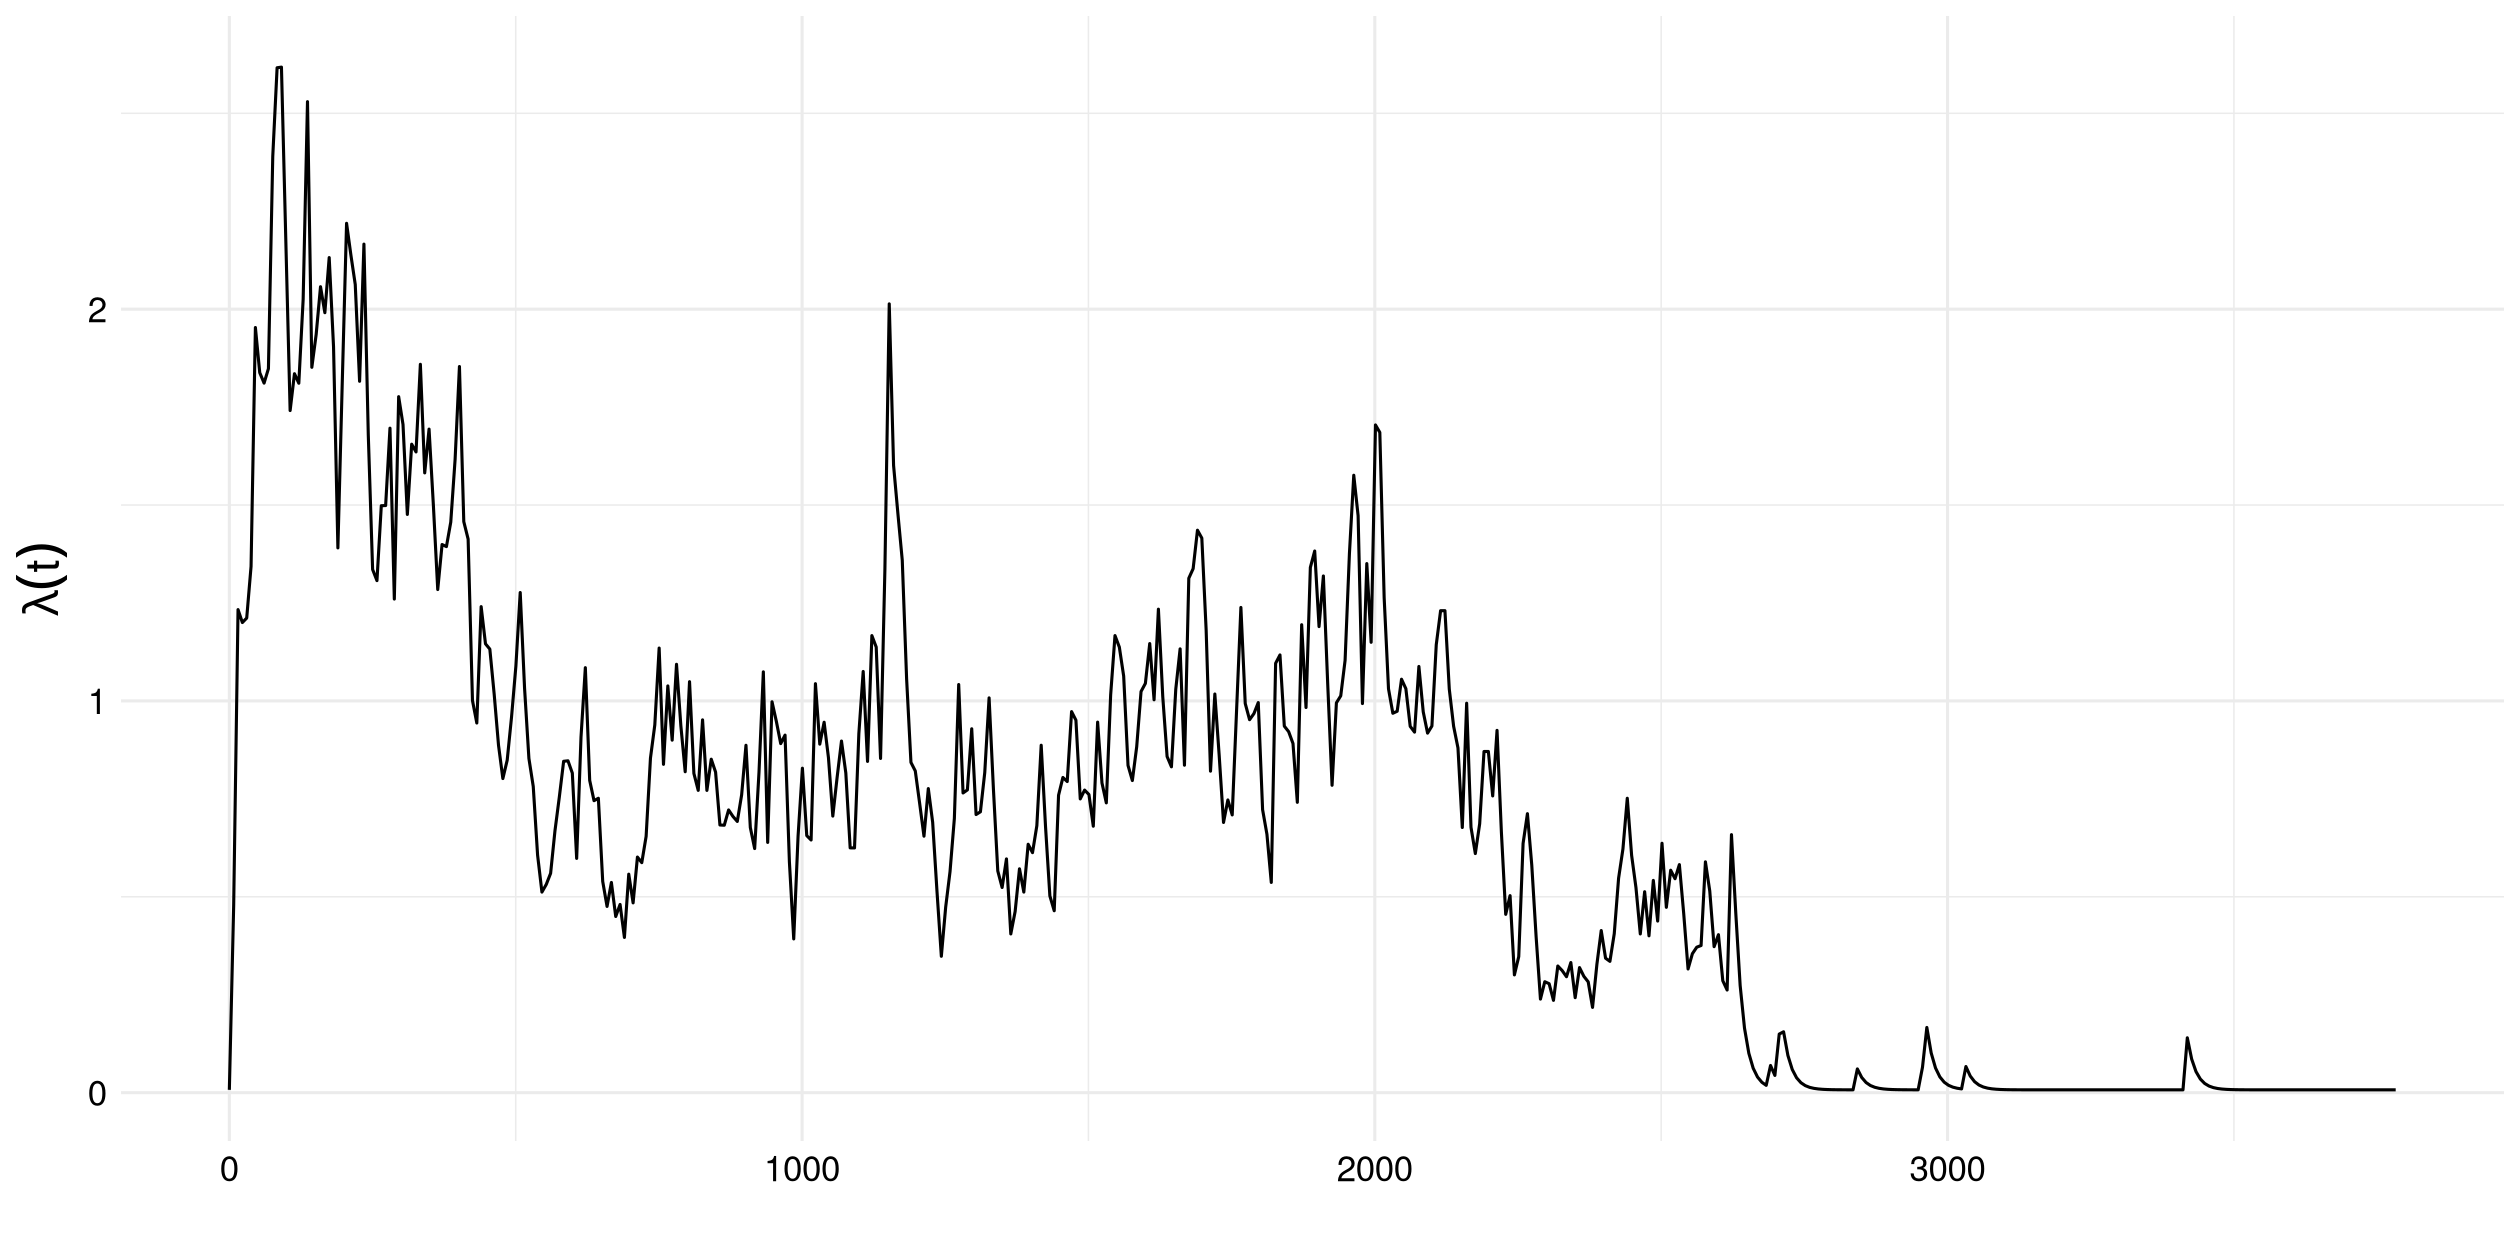

In [68]:
# Set image size
options(repr.plot.width=12, repr.plot.height=6, repr.plot.res = 210)

show_hawkes(fit) + 
  theme(text = element_text(size = 14, color = "black"),
        axis.title = element_text(size = 16, color = "black"),
        axis.text = element_text(size = 12, color = "black"),
        plot.title = element_text(size = 18, color = "black"),
        legend.text = element_text(size = 12, color = "black"),
        legend.title = element_text(size = 14, color = "black"))

Show model parameters

In [69]:
print(round(hawkes_model_coefs, 3))

      Estimate Std. Error
mu       0.007      0.003
alpha    0.068      0.010
beta     0.069      0.010


Negative log-likelihood

In [70]:
print(round(fit$objective, 3))

[1] 2518.828


Goodness of fit plots


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  interarrivals
D = 0.063167, p-value = 3.355e-09
alternative hypothesis: two-sided


	Box-Ljung test

data:  interarrivals
X-squared = 7.4732, df = 1, p-value = 0.006262



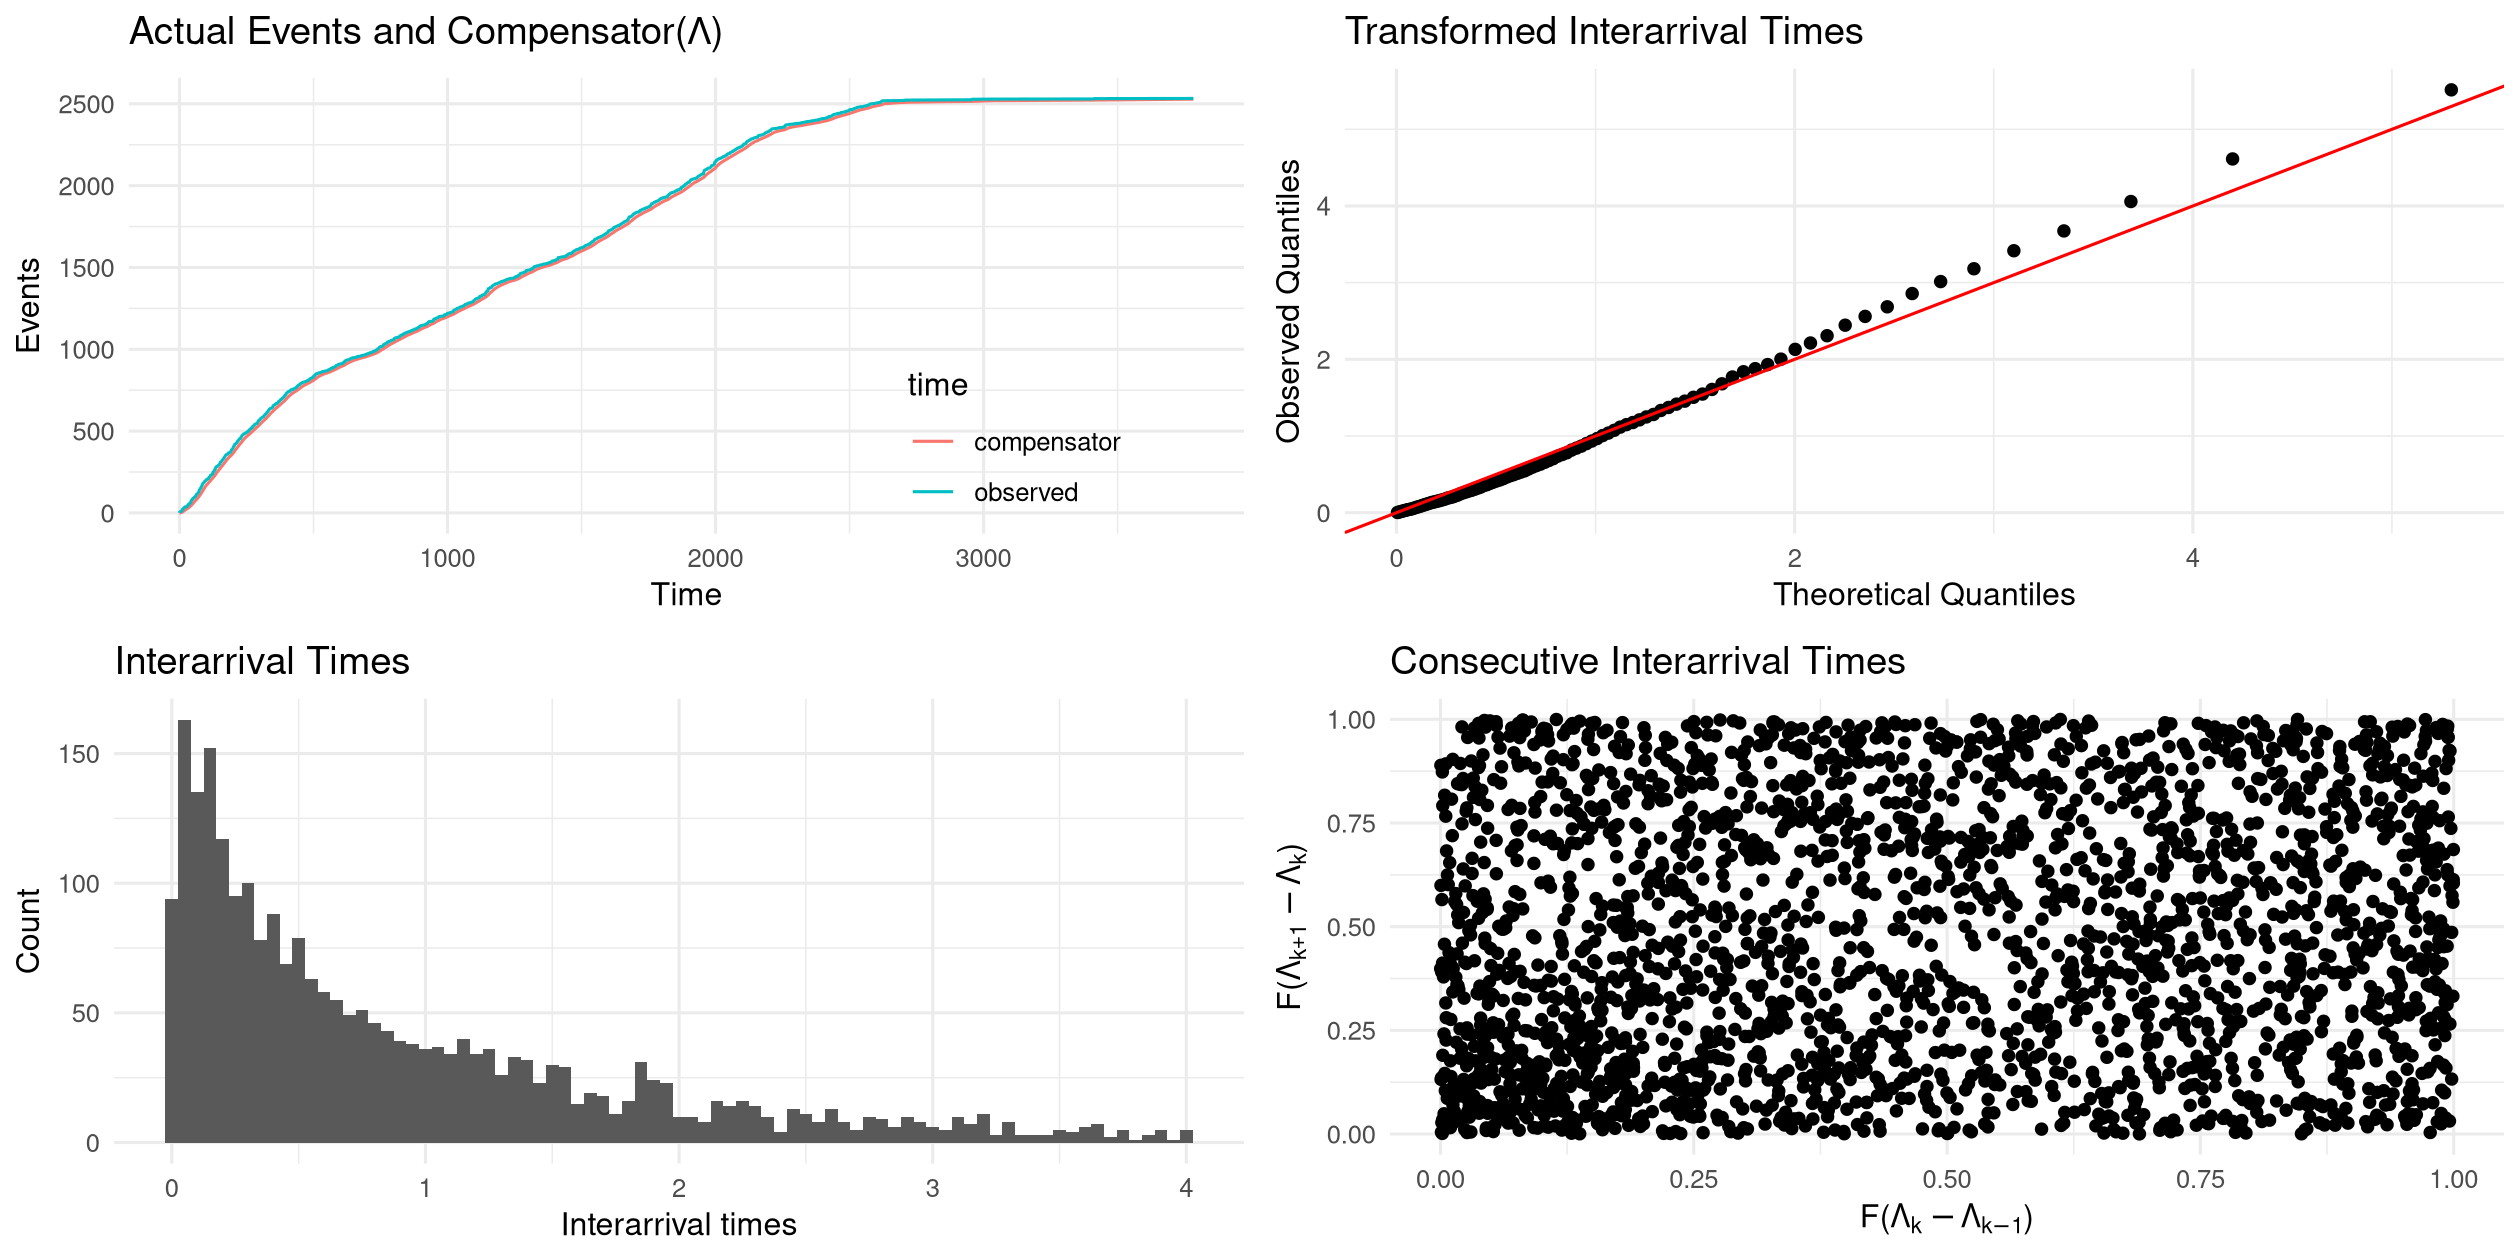

In [71]:
show_hawkes_GOF(fit)
par <- get_coefs(fit)[,1]

### Show version of R and versions of packages used in this analysis

In [72]:
r_version <- R.version

# Format and print the R version details
cat(paste("R version:", r_version$version.string), "\n")
cat(paste("Platform:", r_version$platform), "\n")

R version: R version 4.5.0 (2025-04-11) 
Platform: x86_64-pc-linux-gnu 


In [73]:
loaded_packages <- c("dplyr", "tidyr", "purrr", "stringr", "janitor", 
                     "readxl", "writexl", "skimr", "summarytools", "Hmisc", 
                     "ggplot2", "patchwork", "flextable", "officer", 
                     "MASS", "sf", "maps", "rnaturalearth", "rnaturalearthdata", 
                     "spatstat.geom", "spatstat.linnet", "stpp", 
                     "hawkes", "hawkesbow", "emhawkes", "stelfi", 
                     "inlabru", "INLA")

# Print package names and versions for the specified packages
for (pkg in loaded_packages) {
    version <- packageVersion(pkg)
    cat(paste(pkg, " version: ", version, sep = ""), "\n")
}

dplyr version: 1.1.4 
tidyr version: 1.3.1 
purrr version: 1.1.0 
stringr version: 1.5.2 
janitor version: 2.2.1 
readxl version: 1.4.5 
writexl version: 1.5.4 
skimr version: 2.2.1 
summarytools version: 1.1.4 
Hmisc version: 5.2.3 
ggplot2 version: 4.0.0 
patchwork version: 1.3.2 
flextable version: 0.9.10 
officer version: 0.7.0 
MASS version: 7.3.65 
sf version: 1.0.21 
maps version: 3.4.3 
rnaturalearth version: 1.1.0 
rnaturalearthdata version: 1.0.0 
spatstat.geom version: 3.5.0 
spatstat.linnet version: 3.3.1 
stpp version: 2.0.8 
hawkes version: 0.0.4 
hawkesbow version: 1.0.3 
emhawkes version: 0.9.8 
stelfi version: 1.0.2 
inlabru version: 2.13.0 
INLA version: 25.6.7 
